In [11]:
!pip install pytorch-lightning pandas xarray torchist xskillscore pyyaml zarr tqdm

In [ ]:
# Add your ChaosBench project to Python path
import sys
sys.path.append(r"C:\Users\brand\OneDrive\Desktop\chaosbench-20250319T123539Z-001\chaosbench")  # Adjust this path if needed

In [ ]:
import os
import torch
import yaml
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

import dataset, config, utils, criterion
from models.model import S2SBenchmarkModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Adjust the following paths to match your checkpoint and config locations.
log_dir = Path(r"C:\Users\brand\OneDrive\Desktop\chaosbench-20250319T123539Z-001\chaosbench\logs\lightning_logs\version_28")  
ckpt_dir = log_dir / r"C:\Users\brand\OneDrive\Desktop\ChaosBench-20250319T123531Z-001\ChaosBench\checkpoints"       
ckpt_files = list(ckpt_dir.glob('*.ckpt'))
assert len(ckpt_files) > 0, "No checkpoint found in the specified directory!"
ckpt_filepath = ckpt_files[0] 

# Load model configuration 
config_filepath = Path(r"C:\Users\brand\OneDrive\Desktop\chaosbench-20250319T123539Z-001\chaosbench\configs\fno_pinn_S2S.yaml")
with open(config_filepath, 'r') as config_f:
    hyperparams = yaml.load(config_f, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']

baseline = S2SBenchmarkModel.load_from_checkpoint(
    str(ckpt_filepath),
    model_args=model_args,
    data_args=data_args
)

baseline.eval()  
baseline.to(device)

S2SBenchmarkModel(
  (model): FNO2d(
    (fc0): Linear(in_features=48, out_features=64, bias=True)
    (conv0): SpectralConv2d_fast()
    (conv1): SpectralConv2d_fast()
    (conv2): SpectralConv2d_fast()
    (conv3): SpectralConv2d_fast()
    (w0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (w1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (w2): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (w3): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    (decoder): Sequential(
      (0): Conv2d(1024, 48, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (transformer): Sequential(
    (0): CustomTransformerBlock(
      (attn): PreNorm(
        (fn): EfficientSelfAttention(
          (to_q): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (to_kv): Conv2d(48, 96, kernel_size=(4, 4), stride=(4, 4), bias=False)
          (to_out): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): LayerNorm()
      )
 

In [ ]:
# Prepare the evaluation dataset
BATCH_SIZE = 8
eval_years = [2020]  # Change as needed

# Load the evaluation dataset
input_dataset = dataset.CSV_ERA5_Dataset(
    years=eval_years,
    n_step=config.N_STEPS - 1,  
    lead_time=1,                
    land_vars=data_args.get('land_vars', []),
    ocean_vars=data_args.get('ocean_vars', [])
)
input_dataloader = DataLoader(input_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [16]:
print("Number of samples in dataset:", len(input_dataset))


Number of samples in dataset: 322


In [ ]:
# Perform iterative (autoregressive) inference
# Initialize evaluation metrics 
RMSE_metric = criterion.RMSE()
Bias_metric = criterion.Bias()


all_rmse = []   
all_bias = []  


for batch_idx, (timestamp, preds_x, preds_y) in enumerate(tqdm(input_dataloader, desc="Evaluating")):
    preds_x = preds_x.to(device)
    preds_y = preds_y.to(device)  

    batch_rmse = []
    batch_bias = []

    # For each time step, run inference and update predictions.
    for step_idx in range(preds_y.size(1)):
        with torch.no_grad():
            preds = baseline(preds_x)  
        targets = preds_y[:, step_idx]

        rmse_val = RMSE_metric(preds, targets).cpu().numpy()
        bias_val = Bias_metric(preds, targets).cpu().numpy()

        # --- Compute denormalized metrics for specific channels ---
        # For u-1000 (channel index 36)
        preds_u1000 = preds[:, 36]
        targets_u1000 = targets[:, 36]

        preds_u1000_np = preds_u1000.cpu().numpy()
        targets_u1000_np = targets_u1000.cpu().numpy()

        denorm_preds_u1000 = utils.denormalize(preds_u1000_np, 'u-1000', 'era5', is_diff=False)
        denorm_targets_u1000 = utils.denormalize(targets_u1000_np, 'u-1000', 'era5', is_diff=False)

        denorm_preds_u1000 = torch.tensor(denorm_preds_u1000, device=device)
        denorm_targets_u1000 = torch.tensor(denorm_targets_u1000, device=device)

        rmse_u1000 = RMSE_metric(denorm_preds_u1000, denorm_targets_u1000).cpu().numpy()

        # For v-1000 (channel index 46)
        preds_v1000 = preds[:, 46]
        targets_v1000 = targets[:, 46]

        preds_v1000_np = preds_v1000.cpu().numpy()
        targets_v1000_np = targets_v1000.cpu().numpy()

        denorm_preds_v1000 = utils.denormalize(preds_v1000_np, 'v-1000', 'era5', is_diff=False)
        denorm_targets_v1000 = utils.denormalize(targets_v1000_np, 'v-1000', 'era5', is_diff=False)

        denorm_preds_v1000 = torch.tensor(denorm_preds_v1000, device=device)
        denorm_targets_v1000 = torch.tensor(denorm_targets_v1000, device=device)

        rmse_v1000 = RMSE_metric(denorm_preds_v1000, denorm_targets_v1000).cpu().numpy()

        batch_rmse.append((rmse_val, rmse_u1000, rmse_v1000))
        batch_bias.append(bias_val)

        preds_x = preds

    all_rmse.append(batch_rmse)
    all_bias.append(batch_bias)


Evaluating: 100%|██████████| 41/41 [01:20<00:00,  1.98s/it]


In [37]:
!pip install matplotlib

In [ ]:
import pandas as pd

df = pd.read_csv("rmse_graphcast.csv", header=None)  
print(df.head())


    0                   1                   2                   3    \
0  z-10                z-50               z-100               z-200   
1   NaN   16.15295294179277  12.809589522794012  13.351289704355231   
2   NaN  22.280528119688512  16.934657505537587  16.942449670774447   
3   NaN  28.581447710578768  21.986253432051072  22.369786934137267   
4   NaN  35.722041509519165  28.269349917574438  29.960064124460075   

                  4                   5                   6    \
0               z-300               z-500               z-700   
1  13.388047433164587   9.777885501014794  7.6411706518064655   
2  16.654101979063395   11.92063070316163   9.383122390580434   
3  22.439246608716488  15.933837761027245  12.458435046599796   
4  30.960252873145738   22.25703451651481   17.25706255931931   

                  7                   8                   9    ...       114  \
0               z-850               z-925              z-1000  ...  sohtc700   
1    7.26332687257246 

In [ ]:
import pandas as pd

ed_rmse_path = r"C:\Users\brand\Downloads\rmse_ed_s2s.csv"
unet_rmse_path= r"C:\Users\brand\Downloads\rmse_unet_s2s.csv"
resnet_rmse_path= r"C:\Users\brand\Downloads\rmse_resnet_s2s.csv"
fno_rmse_path = r"C:\Users\brand\Downloads\rmse_fno_s2s.csv"
fno_rmse=pd.read_csv(fno_rmse_path)

fno_rmse.head()


,z-10,z-50,z-100,z-200,z-300,z-500,z-700,z-850,z-925,z-1000,...,sohtc700,sohtcbtm,sometauy,somxl010,somxl030,sosaline,sossheig,sosstsst,sowaflup,sozotaux
0,1066.659142,655.115191,680.406162,862.333068,794.411291,76.177682,413.076065,130.865310,127.014054,119.306533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1049.438601,657.720577,762.578988,1009.814432,884.296438,81.695670,433.006747,146.567648,120.559373,112.554719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1047.228251,657.269582,764.132539,1011.383137,881.379228,82.602577,432.258762,146.518885,120.291795,112.484106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1047.636385,657.489219,764.076610,1011.675935,882.291815,83.474976,432.413809,146.485709,120.203980,112.447317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1047.872584,657.725734,764.318370,1012.291866,883.067517,84.116383,432.604258,146.500063,120.197805,112.459506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


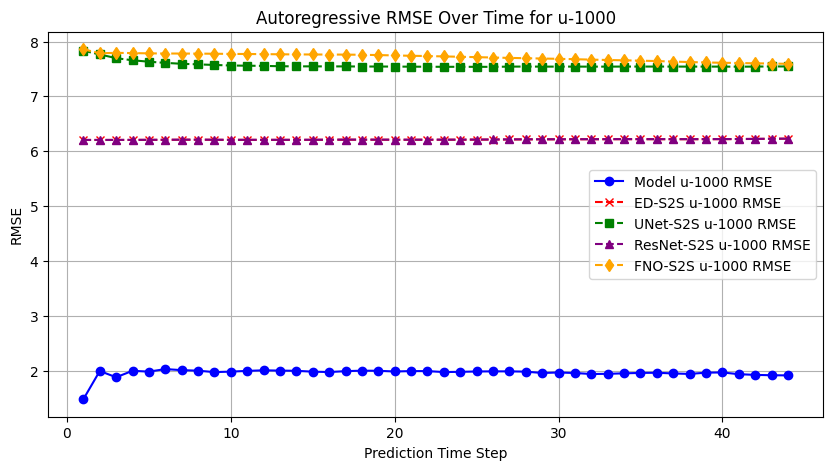

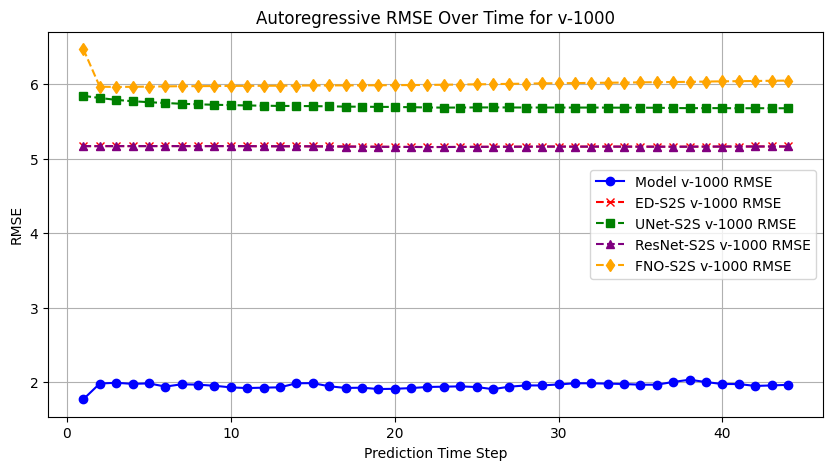

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths
ed_rmse_path = r"C:\Users\brand\Downloads\rmse_ed_s2s.csv"
unet_rmse_path = r"C:\Users\brand\Downloads\rmse_unet_s2s.csv"
resnet_rmse_path = r"C:\Users\brand\Downloads\rmse_resnet_s2s.csv"
fno_rmse_path = r"C:\Users\brand\Downloads\rmse_fno_s2s.csv"

# Load RMSE data
ed_rmse = pd.read_csv(ed_rmse_path)
unet_rmse = pd.read_csv(unet_rmse_path)
resnet_rmse = pd.read_csv(resnet_rmse_path)
fno_rmse = pd.read_csv(fno_rmse_path)

# Extract RMSE values for u-1000 and v-1000 from different models
ed_u1000_rmse = ed_rmse["u-1000"].values
ed_v1000_rmse = ed_rmse["v-1000"].values

unet_u1000_rmse = unet_rmse["u-1000"].values
unet_v1000_rmse = unet_rmse["v-1000"].values

resnet_u1000_rmse = resnet_rmse["u-1000"].values
resnet_v1000_rmse = resnet_rmse["v-1000"].values

fno_u1000_rmse = fno_rmse["u-1000"].values
fno_v1000_rmse = fno_rmse["v-1000"].values

all_rmse = np.array(all_rmse) 

mean_u1000 = np.nanmean(all_rmse[:, :, 1], axis=0)
mean_v1000 = np.nanmean(all_rmse[:, :, 2], axis=0)

timesteps = np.arange(1, mean_u1000.size + 1)

# Plot RMSE for u-1000
plt.figure(figsize=(10, 5))
plt.plot(timesteps, mean_u1000, marker='o', label='Model u-1000 RMSE', color='blue')
plt.plot(timesteps[:len(ed_u1000_rmse)], ed_u1000_rmse, marker='x', linestyle='--', label='ED-S2S u-1000 RMSE', color='red')
plt.plot(timesteps[:len(unet_u1000_rmse)], unet_u1000_rmse, marker='s', linestyle='--', label='UNet-S2S u-1000 RMSE', color='green')
plt.plot(timesteps[:len(resnet_u1000_rmse)], resnet_u1000_rmse, marker='^', linestyle='--', label='ResNet-S2S u-1000 RMSE', color='purple')
plt.plot(timesteps[:len(fno_u1000_rmse)], fno_u1000_rmse, marker='d', linestyle='--', label='FNO-S2S u-1000 RMSE', color='orange')
plt.xlabel("Prediction Time Step")
plt.ylabel("RMSE")
plt.title("Autoregressive RMSE Over Time for u-1000")
plt.legend()
plt.grid(True)
plt.show()

# Plot RMSE for v-1000
plt.figure(figsize=(10, 5))
plt.plot(timesteps, mean_v1000, marker='o', label='Model v-1000 RMSE', color='blue')
plt.plot(timesteps[:len(ed_v1000_rmse)], ed_v1000_rmse, marker='x', linestyle='--', label='ED-S2S v-1000 RMSE', color='red')
plt.plot(timesteps[:len(unet_v1000_rmse)], unet_v1000_rmse, marker='s', linestyle='--', label='UNet-S2S v-1000 RMSE', color='green')
plt.plot(timesteps[:len(resnet_v1000_rmse)], resnet_v1000_rmse, marker='^', linestyle='--', label='ResNet-S2S v-1000 RMSE', color='purple')
plt.plot(timesteps[:len(fno_v1000_rmse)], fno_v1000_rmse, marker='d', linestyle='--', label='FNO-S2S v-1000 RMSE', color='orange')
plt.xlabel("Prediction Time Step")
plt.ylabel("RMSE")
plt.title("Autoregressive RMSE Over Time for v-1000")
plt.legend()
plt.grid(True)
plt.show()


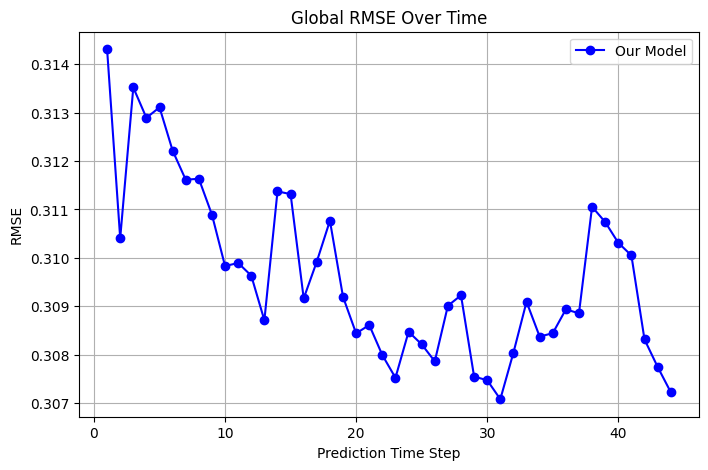

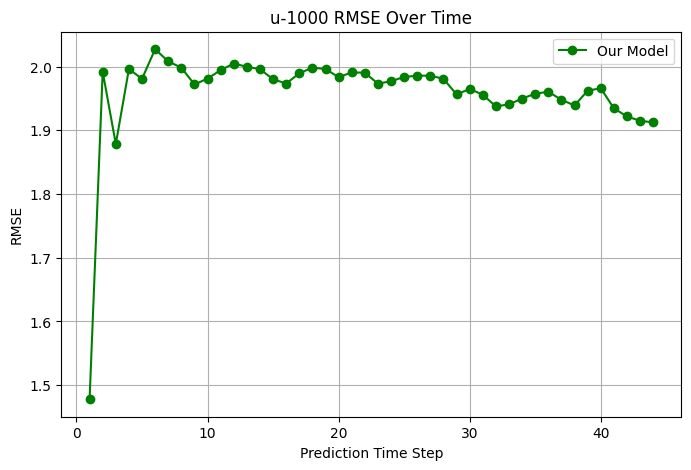

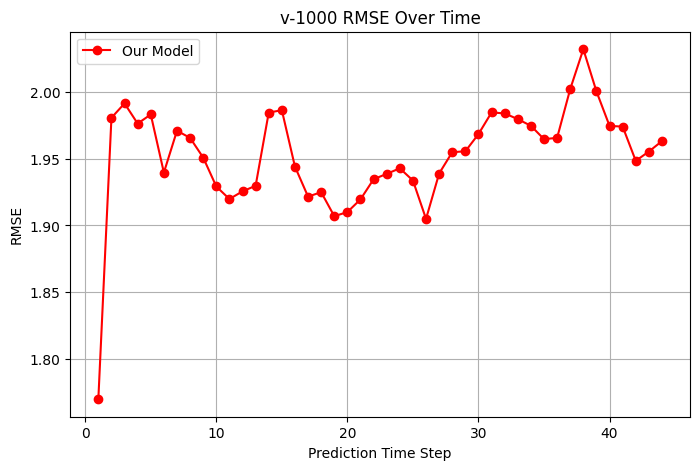

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Convert all_rmse (a list of lists of tuples) to separate NumPy arrays
# Shape: (num_batches, num_timesteps, 3) -> (Global, u-1000, v-1000)
all_rmse = np.array(all_rmse)

# Compute mean across batches for each metric separately
mean_global = np.nanmean(all_rmse[:, :, 0], axis=0)
mean_u1000 = np.nanmean(all_rmse[:, :, 1], axis=0)
mean_v1000 = np.nanmean(all_rmse[:, :, 2], axis=0)

timesteps = np.arange(1, mean_global.size + 1)

# Plot Global RMSE
plt.figure(figsize=(8, 5))
plt.plot(timesteps, mean_global, marker='o', label='Our Model', color='blue')
plt.xlabel("Prediction Time Step")
plt.ylabel("RMSE")
plt.title("Global RMSE Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot u-1000 RMSE separately
plt.figure(figsize=(8, 5))
plt.plot(timesteps, mean_u1000, marker='o', label='Our Model', color='green')
plt.xlabel("Prediction Time Step")
plt.ylabel("RMSE")
plt.title("u-1000 RMSE Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot v-1000 RMSE separately
plt.figure(figsize=(8, 5))
plt.plot(timesteps, mean_v1000, marker='o', label='Our Model', color='red')
plt.xlabel("Prediction Time Step")
plt.ylabel("RMSE")
plt.title("v-1000 RMSE Over Time")
plt.legend()
plt.grid(True)
plt.show()

